<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/ST_HISTOARMONICOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

# Definición de las señales

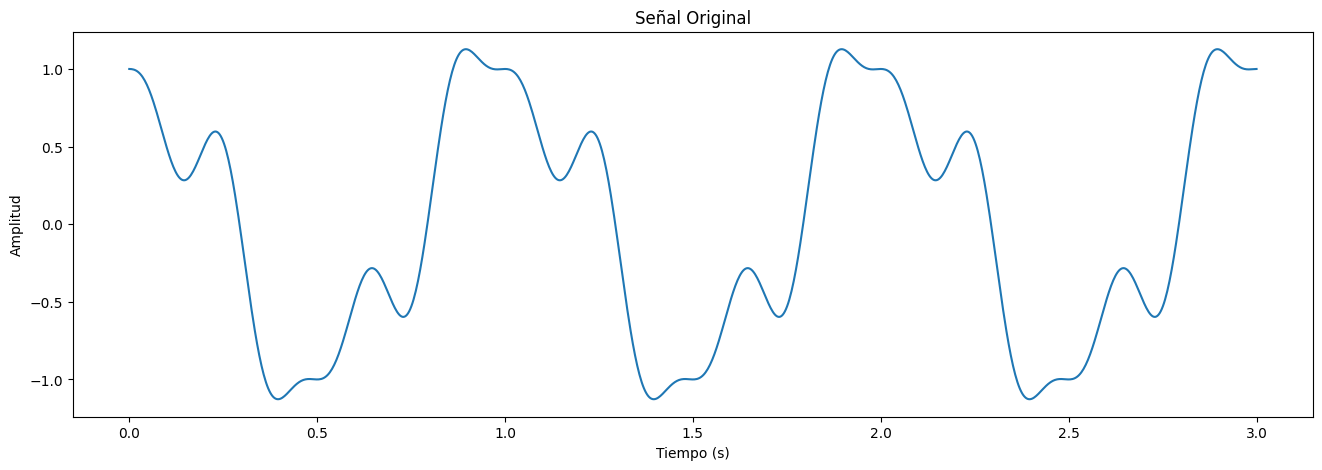

In [ ]:
#Frecuencia angular general y vector de tiempo
f = 1
w = 2*np.pi*f
T = 3
N = 1024 #puntos en la señal
fs= N/T #frecuencia de muestreo
t = np.linspace(0,T,N)

#Señales particulares
x1 = np.cos(w*t)
x2 = 1/3*(np.sin(3*w*t))
x3 = 1/5*(np.sin(5*w*t))
#Señal original para la red
xt = x1-x2+x3

plt.figure(figsize=(16,5))
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,xt)
plt.show()

In [ ]:
#Generador de ruido blanco gausiano para crear la matriz con señales ruidosas
def generate_gaussian_noise(mean=0, stds=[0.1,0.3,1,3], size=1024, num_signals=250):
    R = []

    for std in stds:
      for i in range(0,num_signals,1):
        noise = np.random.normal(0, std, size)
        noisy_signal = xt + noise
        R.append(noisy_signal)
    return np.array(R)

In [ ]:
M = generate_gaussian_noise()

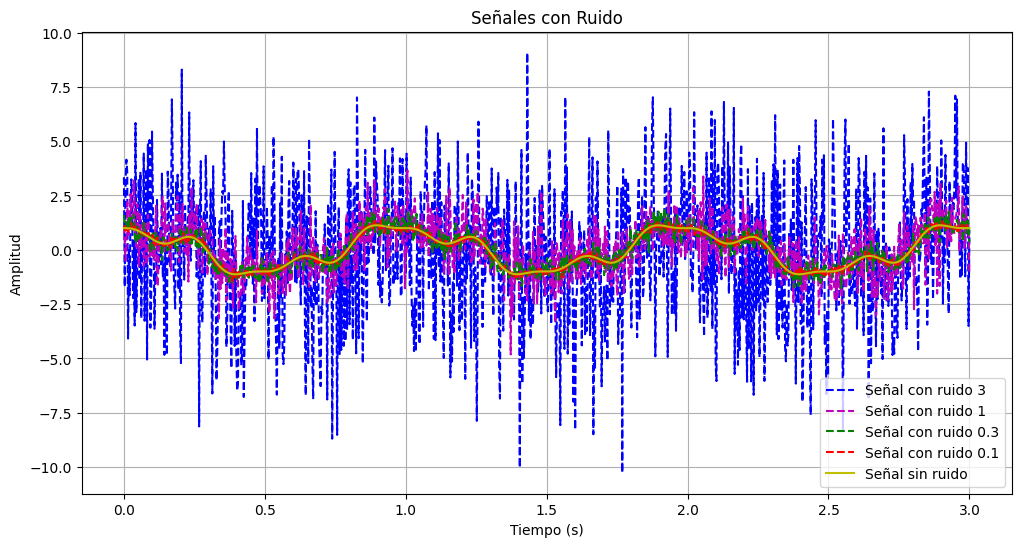

In [ ]:
#Verificación de las señales con ruido blanco gaussiano y la señal original
plt.figure(figsize=(12,6))
plt.title('Señales con Ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,M[750], 'b',label = 'Señal con ruido 3', linestyle = '--') #Ruido 3 = 750 a 999
plt.plot(t,M[500], 'm',label = 'Señal con ruido 1', linestyle = '--') #Ruido 1 = 500 a 749
plt.plot(t,M[250], 'g', label = 'Señal con ruido 0.3', linestyle = '--') #Ruido 0.3 = 250 a 499
plt.plot(t,M[0],'r', label = 'Señal con ruido 0.1', linestyle = '--')  #Ruido 0.1 = 0 a 249
plt.plot(t,xt, 'y', label = 'Señal sin ruido', linewidth=1.5)
plt.grid(True)
plt.legend()
plt.show()

# Cálculo del PSD (Welch)

In [ ]:
def calculate_psd(signals,fs,nperseg):
    fr,PSD = signal.welch(signals,fs=fs,nperseg=nperseg)
    return fr,PSD

In [ ]:
fr, Wt = calculate_psd(xt,fs,N) #PSD Señal original

In [ ]:
fr, Wr = calculate_psd(M,fs,N) #PSD Matriz con señales ruidosas

<ipython-input-9-69957a4a5d8a>:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-5,0)


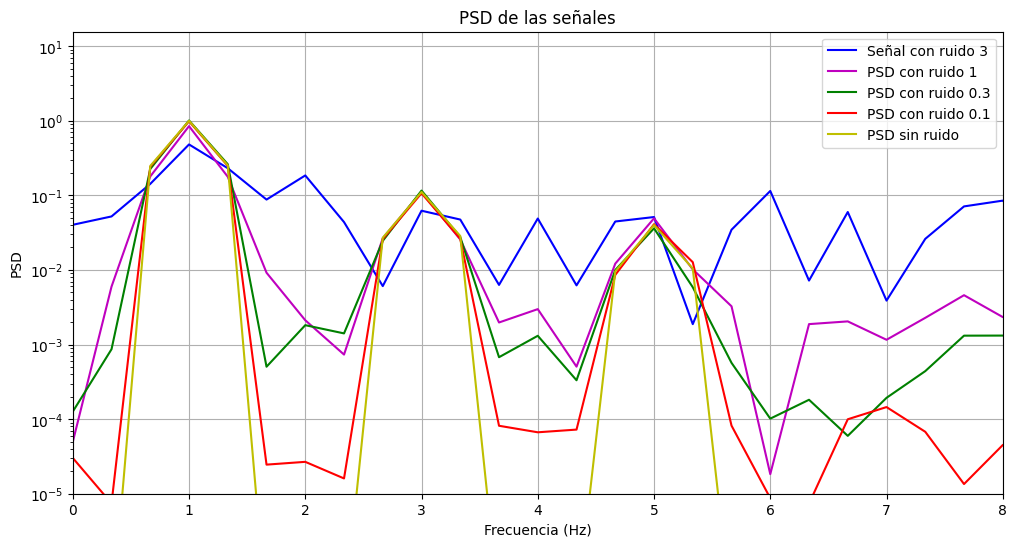

In [ ]:
#Visualización del PSD de las señales (original y con ruido)
plt.figure(figsize=(12,6))
plt.title('PSD de las señales')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.semilogy(fr,Wr[750], 'b',label = 'Señal con ruido 3')
plt.semilogy(fr,Wr[500],'m', label="PSD con ruido 1")
plt.semilogy(fr,Wr[250],'g', label="PSD con ruido 0.3")
plt.semilogy(fr,Wr[0],'r', label="PSD con ruido 0.1")
plt.semilogy(fr,Wt, 'y', label="PSD sin ruido")
plt.xlim(0,8)
plt.ylim(10**-5,0)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
PSDprom = np.mean(Wr,axis=0)

In [ ]:
#dimensiones de los datos(importante para la red) generar varias señales para el entrenamiento
print(len(xt))     #todas las señales tienen 1024 puntos (entrada de la red)
print(len(Wt)) #todos los psd calculados tienen 513 puntos (salida de la red)

1024
513


# Modelo de la red MLP para predecir PSD

In [ ]:
PSDpromm = np.tile(PSDprom, (1000, 1))

In [ ]:
#Separación de datos
x_train, x_test, y_train, y_test = train_test_split(M, PSDpromm, test_size=0.3, random_state=40)

In [ ]:
model=Sequential()
model.add(Dense(128,activation='relu',input_dim=N))
model.add(Dense(64,activation='elu'))
model.add(Dense(513,activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',metrics=['accuracy'])

history=model.fit(x_train,y_train,epochs=25,batch_size=16, validation_split=0.3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 3.3002e-04 - loss: 0.3855 - val_accuracy: 0.0047 - val_loss: 0.2360
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0011 - loss: 0.1724 - val_accuracy: 0.0095 - val_loss: 0.1785
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0058 - loss: 0.1055 - val_accuracy: 0.0190 - val_loss: 0.1481
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0084 - loss: 0.0804 - val_accuracy: 0.0332 - val_loss: 0.1277
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0173 - loss: 0.0718 - val_accuracy: 0.0284 - val_loss: 0.1132
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0259 - loss: 0.0512 - val_accuracy: 0.0616 - val_loss: 0.1030
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0690 - loss: 0.0472 - val_accuracy: 0.0900 - val_loss: 0.0945
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1145 - loss: 0.0363 - val_accuracy: 0.2607 - val_

# Loss y Accuracy

Text(0.5, 1.0, 'Model Loss')

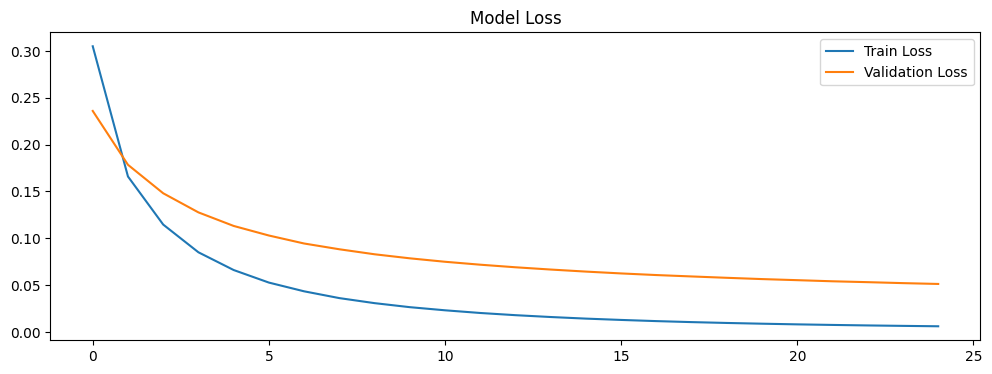

In [ ]:
#Visualización perdida del entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

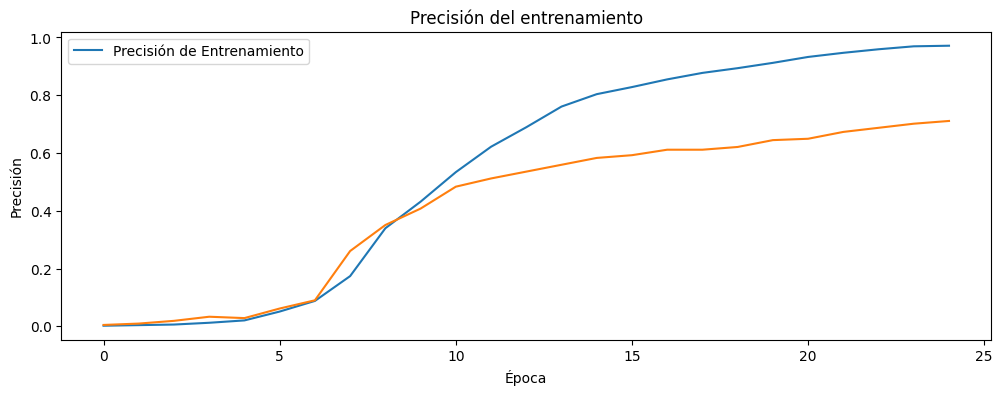

In [ ]:
#Visualización de la precisión del modelo
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Precisión de Entrenamiento'])
plt.show()

In [ ]:
#Porcentaje de precisión y perdida del modelo
test_loss, test_acc = model.evaluate(x_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7243 - loss: 0.0509 


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 513)                 │          33,345 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 518,405 (1.98 MB)

 Trainable params: 172,801 (675.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 345,604 (1.32 MB)

# Reconstrucción de la señal

In [ ]:
#Generación de la matriz con los resultados predichos con el modelo
y = model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<ipython-input-43-3c1489a1b57b>:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-4,0)


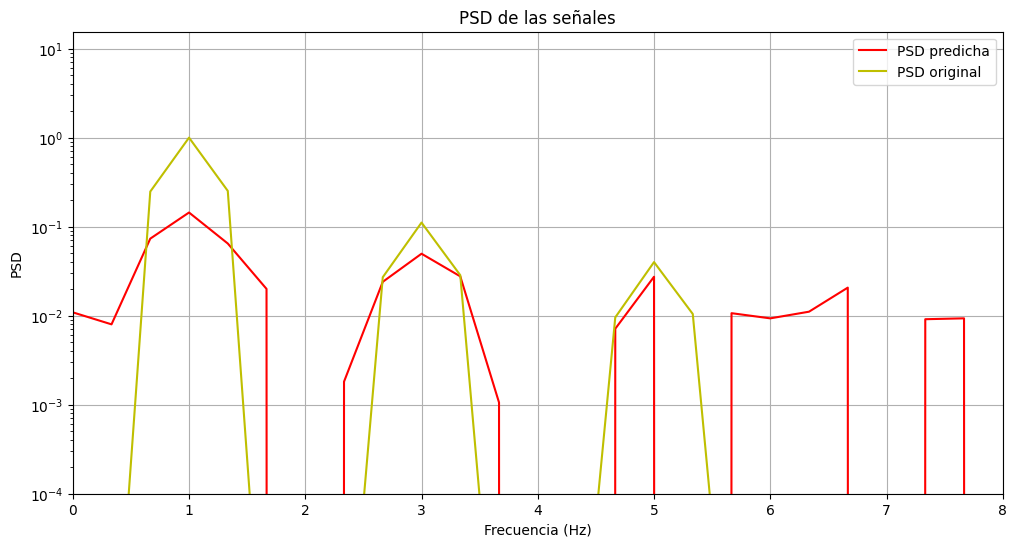

In [ ]:
plt.figure(figsize=(12,6))
plt.title('PSD de las señales')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.semilogy(fr,y[0],'r', label="PSD predicha")
plt.semilogy(fr,Wt, 'y', label="PSD original")
plt.xlim(0,8)
plt.ylim(10**-4,0)
plt.grid(True)
plt.legend()
plt.show()

#Implementación del umbral

In [ ]:
def umbral(signal):
  hist, bin_edges = np.histogram(signal, bins=50)

  percentile_threshold = 95
  threshold = np.percentile(signal, percentile_threshold)

  filtered_signal = np.where(signal >= threshold, signal, 0)

  # Visualizar el histograma y el umbral
  plt.figure(figsize=(16, 5))
  plt.title("Histograma")
  plt.hist(signal, bins=50, alpha=0.7, label='Señal original')
  plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Umbral ({percentile_threshold}%)')
  plt.xlim(-0.030,0.050)
  plt.legend()
  plt.show()

  # Encontrar el índice del armónico más alto
  idx_armonico = np.argmax(signal)
  freq_armonico = fr[idx_armonico]
  potencia_armonico = signal[idx_armonico]

  # Visualizar el umbral en la señal y marcar el armónico más alto
  plt.figure(figsize=(16, 5))
  plt.title("Umbral para el primer armónico")
  plt.plot(fr, signal, label="PSD Señal")
  plt.axhline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Umbral ({percentile_threshold}%)')
  plt.scatter(freq_armonico, potencia_armonico, color='green', marker='x', s=100, label=f'Armónico más alto\nFrecuencia: {freq_armonico} Hz\nPotencia: {potencia_armonico:.2f}')
  plt.xlim(0, 10)  # Ajusta los límites de la frecuencia según sea necesario
  plt.legend()
  plt.show()

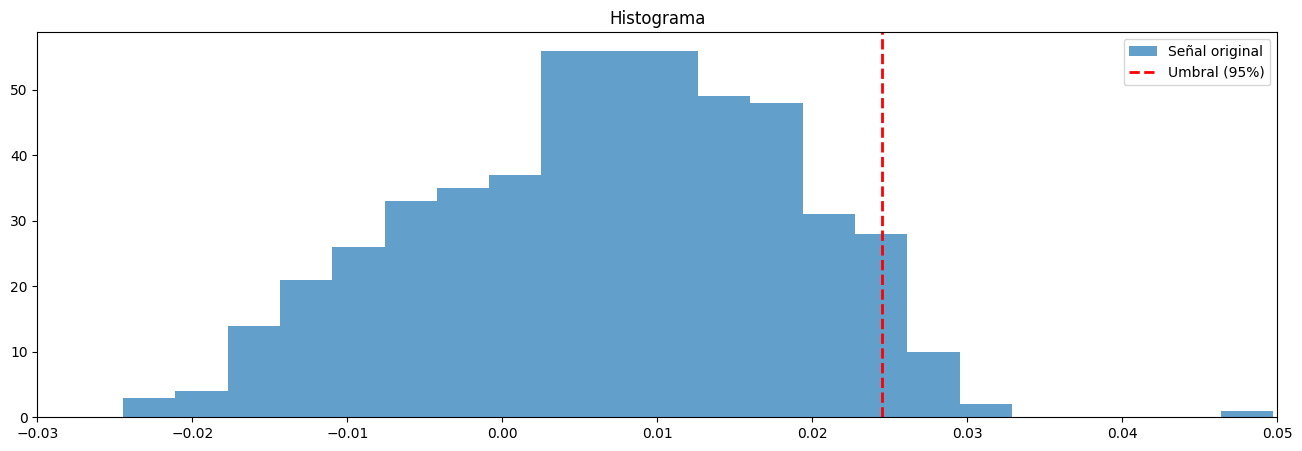

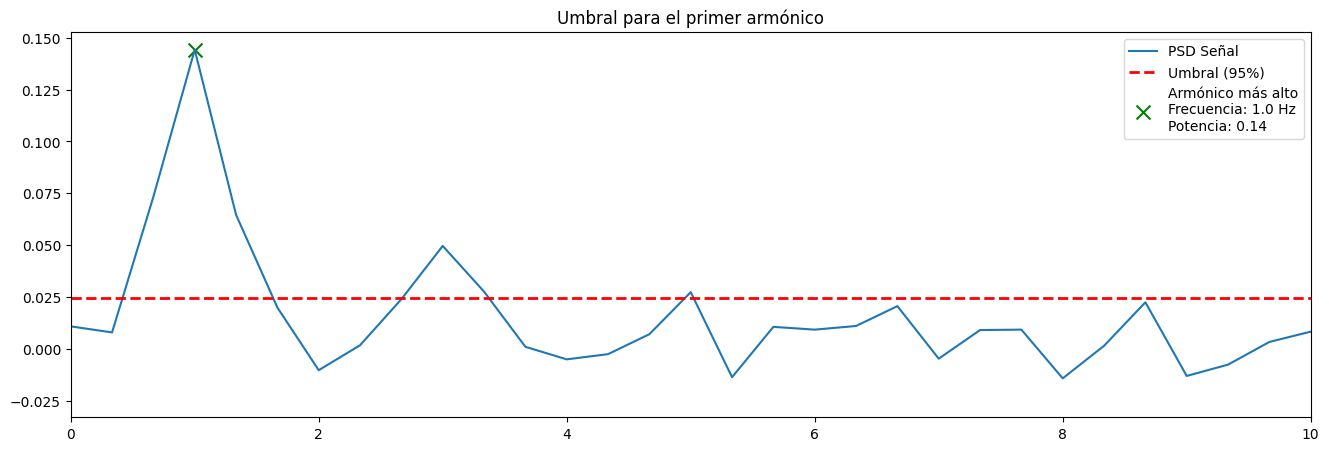

In [ ]:
umbral(y[0])

#  Clase 13 Agosto 2024

TAREA 1

Reconstruir la señal, conociendo las frecuencias de los 3 armonicos y su respectiva potencia.

In [ ]:
def find_harmonics(fr, PSD, n_armonicos=3):
    # Encontrar todos los picos en el PSD
    picos, _ = find_peaks(PSD)
    # Ordenar los picos según la potencia
    ordenar_picos = sorted(picos, key=lambda x: PSD[x], reverse=True)
    # Seleccionar los primeros picos
    armonicos = ordenar_picos[:n_armonicos]
    # Obtener las frecuencias y potencias correspondientes
    freqs = fr[armonicos]
    potencias = PSD[armonicos]

    return freqs, potencias

freqs, potencias = find_harmonics(fr, y[0])

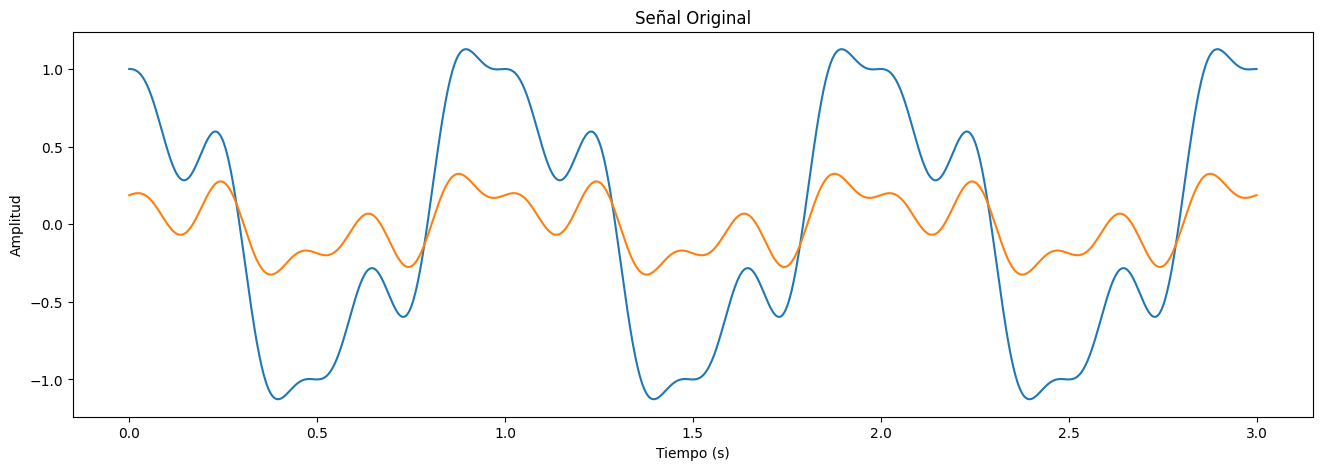

In [ ]:
x1r= np.sqrt(potencias[0])*np.cos(w*t)
x2r= np.sqrt(potencias[1])*(np.sin(3*w*t))
x3r= np.sqrt(potencias[2])*(np.sin(5*w*t))

#Señal original para la red
xtr = x1r-x2r+x3r

plt.figure(figsize=(16,5))
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,xt,label= 'señal original')
plt.plot(t,xtr,label= 'señal reconstruida')
plt.show()

TAREA 2:

Recontruir la señal sin conocer las frecuencias pero identificando por medio del codigo los tres picos más altos de la señal y su respectiva frecuencia y potencia.

In [ ]:
max1=y[10].max()
max2=0
max3=0
for i in range(0,len(fr)):
  if y[10][i] >= max1:
    max1 = y[10][i]
    fr1= fr[i]
  elif y[10][i] >= max2:
    max2 = y[10][i]
    fr2 = fr[i]
  elif y[10][i] >= max3:
    max3 = y[10][i]
    fr3 = fr[i]

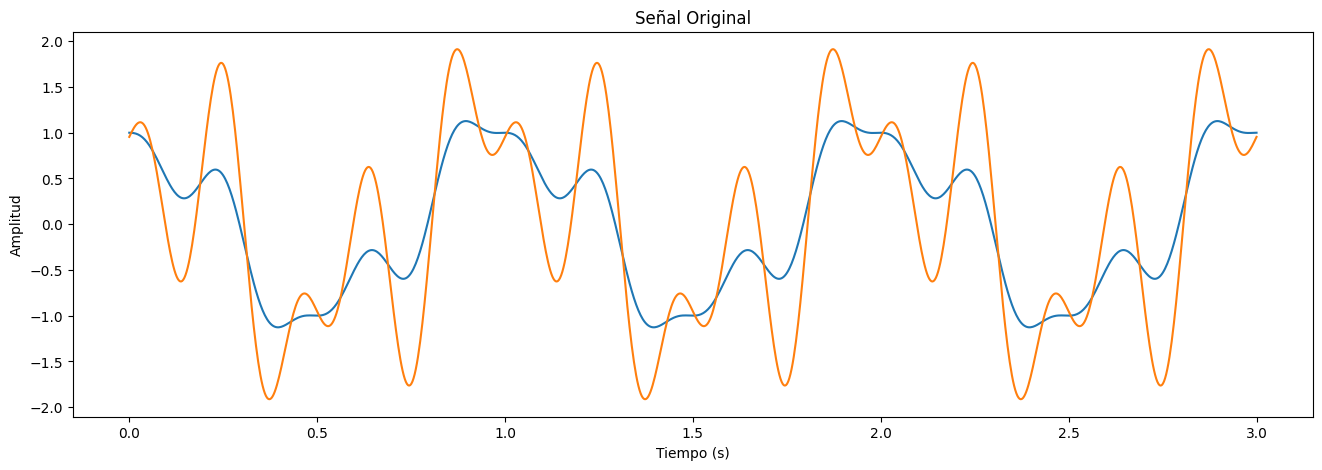

In [ ]:
x1m= np.sqrt(max1)*np.cos(w*t)
x2m= np.sqrt(max2)*(np.sin(3*w*t))
x3m= np.sqrt(max3)*(np.sin(5*w*t))

#Señal original para la red
xtm = x1m-x2m+x3m

plt.figure(figsize=(16,5))
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,xt,label= 'señal original')
plt.plot(t,xtm,label= 'señal reconstruida')
plt.show()

In [ ]:
mae = np.mean(np.abs(xt - xtr))
print(f"Mean Absolute Error :",mae*100)

mse = np.sqrt(np.sum((xt - xtr) ** 2))
print(f"Mean Square Error :",mse)

mae = np.mean(np.abs(xt - xtm))
print(f"Mean Absolute Error :",mae*100)

mse = np.sqrt(np.sum((xt - xtm) ** 2))
print(f"Mean Square Error :",mse)

Mean Absolute Error : 53.7873286392951
Mean Square Error : 18.935082137500913
Mean Absolute Error : 49.11875550438921
Mean Square Error : 19.475907995303146


# Histograma de cada Armonico

In [ ]:
armonico1 = []
armonico2 = []
armonico3 = []

for i in range(len(y)):
    armonico1.append(y[i][np.argmin(np.abs(fr - 1))])
    armonico2.append(y[i][np.argmin(np.abs(fr - 3))])
    armonico3.append(y[i][np.argmin(np.abs(fr - 5))])

In [ ]:
arm1 = np.array(armonico1)
arm2 = np.array(armonico2)
arm3 = np.array(armonico3)

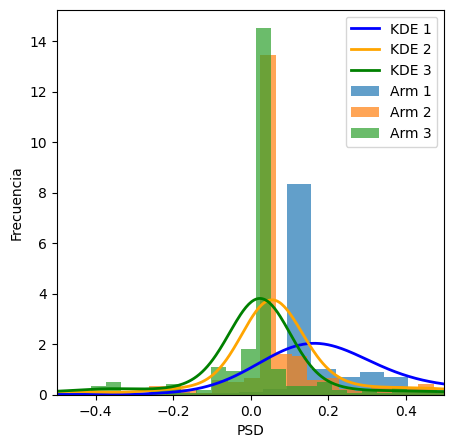

In [ ]:
# Crear la estimación de densidad (KDE) para cada conjunto de datos
kde1 = gaussian_kde(arm1)
kde2 = gaussian_kde(arm2)
kde3 = gaussian_kde(arm3)

# Generar un rango de valores X para trazar las curvas KDE
x_values = np.linspace(min(arm1.min(), arm2.min(), arm3.min()),
                       max(arm1.max(), arm2.max(), arm3.max()), 1000)

# Dibujar las curvas KDE
plt.figure(figsize=(5, 5))
plt.plot(x_values, kde1(x_values), color='blue', linestyle='-', linewidth=2, label='KDE 1')
plt.plot(x_values, kde2(x_values), color='orange', linestyle='-', linewidth=2, label='KDE 2')
plt.plot(x_values, kde3(x_values), color='green', linestyle='-', linewidth=2, label='KDE 3')

# Dibujar histogramas
plt.hist(arm1, bins=50, alpha=0.7, density=True, label='Arm 1')
plt.hist(arm2, bins=50, alpha=0.7, density=True, label='Arm 2')
plt.hist(arm3, bins=50, alpha=0.7, density=True, label='Arm 3')
plt.xlim(-0.5,0.5)

# Añadir leyenda y mostrar gráfico
plt.legend()
plt.xlabel('PSD')
plt.ylabel('Frecuencia')
plt.show()